In [1]:
import sys
import os

import pandas as pd
import numpy as np
from numpy import array
import numdifftools as ndt
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

from datetime import datetime
from time import gmtime, strftime

from math import isclose
from copy import deepcopy
from itertools import product
import importlib
import time
import pickle
import random

import helper_funcs
import HHMM
import optimizor
import stoch_optimizor

# Load in Data

In [2]:
df = pd.read_csv("../../dat/Final_Data_Beth_fine.csv")
df_coarse = pd.read_csv("../../dat/Final_Data_Beth.csv")

df["stime"] = pd.to_datetime(df["stime"])
df["etime"] = pd.to_datetime(df["etime"])

# add dive duration
coarse_features = ['diveDuration']

df = df.merge(df_coarse[['divenum']+coarse_features],
              on = 'divenum',
              how = 'left')

for feature in coarse_features:
    df.loc[df.duplicated(['ID','divenum']),feature] = np.nan

df["w_low"] = np.log(df["w_low"])
df["w_high"] = np.log(df["w_high"])
#df['diveDuration'] = np.exp(df['diveDuration'])

df["delt_d"] = df["ad"].diff()
df["elev"] = -df["ad"]

df = df[df["ID"] == "D26"].iloc[0:1000]
df = df.reset_index()

jump_inds = df.index[~np.isnan(df["diveDuration"])].to_list()

/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_3582/3027845850.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../dat/Final_Data_Beth_fine.csv")


In [3]:
# populate a data object
data = []

initial_ts = [0]
final_ts = []

features = ['delt_d']#'diveDuration','aw1','aw2','aw3','w_low']

means = {feature: df[feature].mean() for feature in features}
stds = {feature: df[feature].std() for feature in features}

for feature in features:#['aw1','aw2','aw3']:
    df[feature] = (df[feature] - means[feature])/stds[feature]

#for feature in ['diveDuration','w_low']:
#    df[feature] = df[feature]/stds[feature]

for t,row in enumerate(df.iterrows()):
    
    if t != 0 and df.iloc[t]["ID"] != df.iloc[t-1]["ID"]:
        final_ts.append(t-1)
        initial_ts.append(t)
     
    data.append({feature : row[1][feature] for feature in features})

final_ts.append(t)

initial_ts = np.array(initial_ts)
final_ts = np.array(final_ts)

print(initial_ts)
print(final_ts)

[0]
[999]


In [4]:
data

[{'delt_d': 6.467387796510125},
 {'delt_d': 2.7000953700378103},
 {'delt_d': 2.6032015270954187},
 {'delt_d': 2.260180163166473},
 {'delt_d': 1.2774986220179534},
 {'delt_d': 0.6812430532723887},
 {'delt_d': 0.4108240103796821},
 {'delt_d': 0.4284912181176939},
 {'delt_d': 0.45067921689225},
 {'delt_d': 0.7188182607623597},
 {'delt_d': -1.1626782538707667},
 {'delt_d': -1.5609254556087613},
 {'delt_d': -1.5967655120182842},
 {'delt_d': -1.862398567410187},
 {'delt_d': -1.5819618737248797},
 {'delt_d': -1.1544515985536228},
 {'delt_d': -0.5350673360424858},
 {'delt_d': -0.31932244358092743},
 {'delt_d': -0.45218323059418586},
 {'delt_d': -0.5271457214088057},
 {'delt_d': -0.10660701543583946},
 {'delt_d': 0.3289141548023564},
 {'delt_d': -0.4391603504671566},
 {'delt_d': -0.9449616782974744},
 {'delt_d': -1.5837831506429703},
 {'delt_d': -1.8951399673834226},
 {'delt_d': -0.4392128083968614},
 {'delt_d': 0.6096986853654996},
 {'delt_d': 0.26647205956226905},
 {'delt_d': 0.01754554688507

# Plot Data

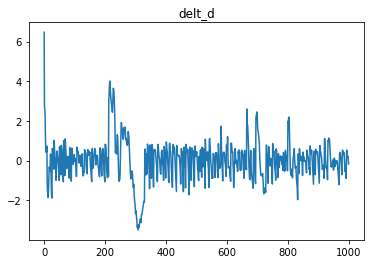

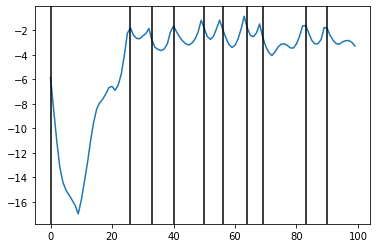

In [5]:
for feature in features:
    plt.plot([datum[feature] for datum in data[:1000] if not np.isnan(datum[feature])])
    plt.title(feature)
    plt.show()
    
df["elev"].iloc[0:100].plot()

for ind in jump_inds:
    if ind < 100:
        plt.axvline(ind,color='k')

# Initialize HMM

In [6]:
importlib.reload(HHMM)
importlib.reload(optimizor)
importlib.reload(stoch_optimizor)

K = [2,3]
T = len(data)

### pick distributions ###
features = {'delt_d'     : {'f'           : 'normal',
                            'lower_bound' : None,
                            'upper_bound' : None,
                            'share_coarse': False,
                            'share_fine'  : True}}

# shared parameters
share_params = []

# pick intial parameters
optim = stoch_optimizor.StochOptimizor(data,features,share_params,K)

optim.initial_ts = initial_ts
optim.final_ts = final_ts
optim.jump_inds = jump_inds


optim.theta = [{'delt_d': {'mu': array([ -1.0, 0.0,  1.0]),
                           'log_sig': array([ -1.0, -1.0, -1.0])}},
               {'delt_d': {'mu': array([ -1.0, 0.0,  1.0]),
                           'log_sig': array([ -1.0, -1.0, -1.0])}}]

optim.eta = [array([[ 0. , -3.0],
                    [-3.0,  0.        ]]),
             [array([[ 0.0  , -1.0  , -100.0],
                     [-100.0, 0.0   , -1.0  ],
                     [-100.0, -100.0, 0.0   ]]),
              array([[ 0.0  , -2.0  , -100.0],
                     [-100.0, 0.0   , -2.0  ],
                     [-100.0, -100.0, 0.0   ]])]]

optim.eta0 = [array([0.0, 0.0]),
             [array([0.0 , -100.0, -100.0]),
              array([0.0 , -100.0, -100.0])]]


optim.get_log_Gamma(jump=False)
optim.get_log_Gamma(jump=True)
optim.get_log_delta()

# print initial parameters
print("initial theta:")
for theta_i in optim.theta:
    for feature in theta_i:
        print(feature)
        print(theta_i[feature])
        print("")
    print("")
print("")
print("initial eta0:")
print(optim.eta0)
print("")
print("initial eta:")
print(optim.eta)
print("")

initial theta:
delt_d
{'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}


delt_d
{'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}



initial eta0:
[array([0., 0.]), [array([   0., -100., -100.]), array([   0., -100., -100.])]]

initial eta:
[array([[ 0., -3.],
       [-3.,  0.]]), [array([[   0.,   -1., -100.],
       [-100.,    0.,   -1.],
       [-100., -100.,    0.]]), array([[   0.,   -2., -100.],
       [-100.,    0.,   -2.],
       [-100., -100.,    0.]])]]



# Define Optimization Parameters

In [7]:
# parse command-line args
max_time = 10*60
id = 1

method_partialEs = [("control",0.0),
                    ("BFGS",0.0),
                    ("CG",0.0),
                    ("GD",0.0),
                    ("SAGA",0.0),
                    ("SAGA",0.5),
                    ("SAGA",1.0),
                    ("SVRG",0.0),
                    ("SVRG",0.5),
                    ("SVRG",1.0)]

rand_seed = [0,1,2,3,4,5,6,7,8,9]

# set methods
for i,settings0 in enumerate(product(rand_seed,method_partialEs)):
    if i == id:
        settings = settings0
        break

rand_seed = settings[0]
method = settings[1][0]
partial_E = settings[1][1]

random.seed(rand_seed)
np.random.seed(rand_seed)

print("method: %s" % method)
print("partial E_step: %.1f" % partial_E)
print("random seed: %d" % rand_seed)
print("max time : %.3f hours" % (max_time/3600))

# select parameters for optimization
num_epochs = 1000
tol = 1e-5
grad_tol = 1e-5

step_sizes = {"EM"  : [None,None],
              "CG"  : [None,None],
              "BFGS": [None,None],
              "GD"  : [0.005,0.005],
              "SGD" : [0.005,0.005],
              "SAG" : [0.005,0.005],
              "SVRG": [0.005,0.005],
              "SAGA": [0.005,0.005]}

### checks on optimization parameters ###
if partial_E > 0 and method in ["EM","BFGS","Nelder-Mead","CG"]:
    raise("partial_E not consistent with method")

### lipschitz constants ###
if method == "control":
    optim.step_size = step_sizes["SAGA"]
    if not (step_sizes["SAGA"][0] is None):
        optim.L_theta = 1.0 / step_sizes["SAGA"][0] #* np.ones(optim.K_total)
        optim.L_eta = 1.0 / step_sizes["SAGA"][1]
else:
    optim.step_size = step_sizes[method]
    if not (step_sizes[method][0] is None):
        optim.L_theta = 1.0 / (3.0 * step_sizes[method][0]) #* np.ones(optim.K_total)
        optim.L_eta = 1.0 / (3.0 * step_sizes[method][1])

method: BFGS
partial E_step: 0.0
random seed: 0
max time : 0.167 hours


# Train the HMM

In [8]:
grad_buffer = "none"
weight_buffer = "none"

# print initial parameters
print("initial theta:")
print(optim.theta)
print("")
print("initial eta0:")
print(optim.eta0)
print("")
print("initial eta:")
print(optim.eta)
print("")
print("parameter bounds:")
print(optim.param_bounds)
print("")
print("length of data:")
print(T)
print("")

# get optimal value via SAGA:
if method == "control":
    optim.train_HHMM_stoch(num_epochs=2*num_epochs,
                         max_time=max_time,
                         method="SAGA",
                         max_epochs=1,
                         partial_E=True,
                         tol=1e-4*tol,
                         grad_tol=1e-4*grad_tol,
                         record_like=True,
                         weight_buffer=weight_buffer,
                         grad_buffer=grad_buffer,
                         buffer_eps=1e-3)

elif partial_E == 0:
    optim.train_HHMM_stoch(num_epochs=num_epochs,
                          max_time=max_time,
                          method=method,
                          max_epochs=1,
                          partial_E=False,
                          tol=tol,
                          grad_tol=grad_tol,
                          record_like=True,
                          weight_buffer=weight_buffer,
                          grad_buffer=grad_buffer,
                          buffer_eps=1e-3)

elif partial_E == 0.5:
    if method in ["SGD","SAG","SVRG","SAGA"]:
        optim.train_HHMM_stoch(num_epochs=num_epochs,
                              max_time=max_time,
                              method=method,
                              max_epochs=1,
                              partial_E=True,
                              tol=tol,
                              grad_tol=grad_tol,
                              record_like=True,
                              weight_buffer=weight_buffer,
                              grad_buffer=grad_buffer,
                              buffer_eps=1e-3)

elif partial_E == 1:
    if method in ["SGD","SAG","SVRG","SAGA"]:
        optim.train_HHMM_stoch(num_epochs=num_epochs,
                              max_time=max_time,
                              method=method,
                              max_epochs=10,
                              partial_E=True,
                              tol=tol,
                              grad_tol=grad_tol,
                              record_like=True,
                              weight_buffer=weight_buffer,
                              grad_buffer=grad_buffer,
                              buffer_eps=1e-3)

initial theta:
[{'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}, {'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}]

initial eta0:
[array([0., 0.]), [array([   0., -100., -100.]), array([   0., -100., -100.])]]

initial eta:
[array([[ 0., -3.],
       [-3.,  0.]]), [array([[   0.,   -1., -100.],
       [-100.,    0.,   -1.],
       [-100., -100.,    0.]]), array([[   0.,   -2., -100.],
       [-100.,    0.,   -2.],
       [-100., -100.,    0.]])]]

parameter bounds:
{'delt_d': {'mu': [-3.500171560346187, 6.467387796510125], 'log_sig': [-5.0, 2.2993357552951514]}}

length of data:
1000

[   0.   -3.   -3.    0.    0.   -1. -100. -100.    0.   -1. -100. -100.
    0.    0.   -2. -100. -100.    0.   -2. -100. -100.    0.    0.    0.
    0. -100. -100.    0. -100. -100.]
-2659.030464654483
-2650.1504904446024
-2621.4611428566245
starting epoch 0.0

0.000 hours elapsed

current log-likelihood:
-2621.4611428566245

current parameters:


-2562.7366007750816
starting epoch 4.0

0.002 hours elapsed

current log-likelihood:
-2562.7366007750816

current parameters:
[{'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}, {'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}]
[array([[ 0.        , -2.99994222],
       [-3.15320197,  0.        ]]), [array([[   0.        ,   -1.00020518, -100.        ],
       [-100.        ,    0.        ,   -1.00005405],
       [ -99.99994625, -100.        ,    0.        ]]), array([[   0.        ,   -2.29415208, -100.        ],
       [-100.        ,    0.        ,   -5.26895054],
       [ -99.87264961, -100.        ,    0.        ]])]]
[array([0.        , 0.02152916]), [array([   0.        , -100.        ,  -99.99994625]), array([   0.        , -100.        ,  -99.95908912])]]

current prior means:
[{'delt_d': {'mu': array([-1.77635684e-18, -1.77635684e-18, -1.77635684e-18]), 'log_sig': array([-1.9464104, -1.9464104, -1.9464104])}}, {'delt_d'

-2561.0246821605124
starting epoch 8.0

0.003 hours elapsed

current log-likelihood:
-2561.0246821605124

current parameters:
[{'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}, {'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}]
[array([[ 0.        , -2.99991253],
       [-3.25413497,  0.        ]]), [array([[   0.        ,   -1.00031356, -100.        ],
       [-100.        ,    0.        ,   -1.00007802],
       [ -99.99991805, -100.        ,    0.        ]]), array([[   0.        ,   -2.46895182, -100.        ],
       [-100.        ,    0.        ,   -6.62311409],
       [ -99.78519628, -100.        ,    0.        ]])]]
[array([0.       , 0.0365173]), [array([   0.        , -100.        ,  -99.99991806]), array([   0.        , -100.        ,  -99.93205359])]]

current prior means:
[{'delt_d': {'mu': array([-1.77635684e-18, -1.77635684e-18, -1.77635684e-18]), 'log_sig': array([-1.9464104, -1.9464104, -1.9464104])}}, {'delt_d': 

-2559.877737771604
starting epoch 12.0

0.005 hours elapsed

current log-likelihood:
-2559.877737771604

current parameters:
[{'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}, {'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}]
[array([[ 0.        , -2.9998655 ],
       [-3.51415901,  0.        ]]), [array([[   0.        ,   -1.00049401, -100.        ],
       [-100.        ,    0.        ,   -1.0001048 ],
       [ -99.99987161, -100.        ,    0.        ]]), array([[   0.        ,   -2.83144205, -100.        ],
       [-100.        ,    0.        ,   -7.57685526],
       [ -99.5353224 , -100.        ,    0.        ]])]]
[array([0.        , 0.07954947]), [array([   0.        , -100.        ,  -99.99987165]), array([   0.        , -100.        ,  -99.85706696])]]

current prior means:
[{'delt_d': {'mu': array([-1.77635684e-18, -1.77635684e-18, -1.77635684e-18]), 'log_sig': array([-1.9464104, -1.9464104, -1.9464104])}}, {'delt_d':

-2552.8420399526804
starting epoch 16.0

0.006 hours elapsed

current log-likelihood:
-2552.8420399526804

current parameters:
[{'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}, {'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}]
[array([[ 0.        , -2.99961865],
       [-5.39963711,  0.        ]]), [array([[   0.        ,   -1.00148546, -100.        ],
       [-100.        ,    0.        ,   -1.00018872],
       [ -99.99961887, -100.        ,    0.        ]]), array([[   0.        ,   -5.15058832, -100.        ],
       [-100.        ,    0.        ,   -6.52209415],
       [ -97.61940563, -100.        ,    0.        ]])]]
[array([0.        , 0.40919758]), [array([   0.        , -100.        ,  -99.99961922]), array([   0.        , -100.        ,  -99.28714185])]]

current prior means:
[{'delt_d': {'mu': array([-1.77635684e-18, -1.77635684e-18, -1.77635684e-18]), 'log_sig': array([-1.9464104, -1.9464104, -1.9464104])}}, {'delt_d

-2552.237870665454
starting epoch 20.0

0.007 hours elapsed

current log-likelihood:
-2552.237870665454

current parameters:
[{'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}, {'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}]
[array([[ 0.        , -2.99953622],
       [-6.05397805,  0.        ]]), [array([[   0.        ,   -1.00181858, -100.        ],
       [-100.        ,    0.        ,   -1.00021418],
       [ -99.99953405, -100.        ,    0.        ]]), array([[   0.        ,   -5.92774897, -100.        ],
       [-100.        ,    0.        ,   -5.89318275],
       [ -96.93477101, -100.        ,    0.        ]])]]
[array([0.        , 0.52620474]), [array([   0.        , -100.        ,  -99.99953451]), array([   0.        , -100.        ,  -99.08302827])]]

current prior means:
[{'delt_d': {'mu': array([-1.77635684e-18, -1.77635684e-18, -1.77635684e-18]), 'log_sig': array([-1.9464104, -1.9464104, -1.9464104])}}, {'delt_d':

-2551.4503659442616
starting epoch 24.0

0.008 hours elapsed

current log-likelihood:
-2551.4503659442616

current parameters:
[{'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}, {'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}]
[array([[ 0.        , -2.99907492],
       [-9.41804762,  0.        ]]), [array([[   0.        ,   -1.00365588, -100.        ],
       [-100.        ,    0.        ,   -1.00039088],
       [ -99.99906484, -100.        ,    0.        ]]), array([[   0.        ,   -9.87286452, -100.        ],
       [-100.        ,    0.        ,   -6.00216246],
       [ -93.29080044, -100.        ,    0.        ]])]]
[array([0.        , 1.14045822]), [array([   0.        , -100.        ,  -99.99906583]), array([   0.        , -100.        ,  -97.98823748])]]

current prior means:
[{'delt_d': {'mu': array([-1.77635684e-18, -1.77635684e-18, -1.77635684e-18]), 'log_sig': array([-1.9464104, -1.9464104, -1.9464104])}}, {'delt_d

-2832.280627586423
-2541.208308325713
starting epoch 28.0

0.010 hours elapsed

current log-likelihood:
-2541.208308325713

current parameters:
[{'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}, {'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}]
[array([[  0.        ,  -2.9883215 ],
       [-88.04864216,   0.        ]]), [array([[   0.        ,   -1.04649995, -100.        ],
       [-100.        ,    0.        ,   -1.00449212],
       [ -99.98812391, -100.        ,    0.        ]]), array([[   0.        , -101.12493248, -100.        ],
       [-100.        ,    0.        ,   -6.53949547],
       [  -7.24727682, -100.        ,    0.        ]])]]
[array([ 0.       , 15.5894565]), [array([   0.        , -100.        ,  -99.98813738]), array([   0.        , -100.        ,  -72.10982917])]]

current prior means:
[{'delt_d': {'mu': array([-1.77635684e-18, -1.77635684e-18, -1.77635684e-18]), 'log_sig': array([-1.9464104, -1.9464104, -1.

-2540.273850423057
starting epoch 32.0

0.012 hours elapsed

current log-likelihood:
-2540.273850423057

current parameters:
[{'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}, {'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}]
[array([[  0.        ,  -2.98823721],
       [-88.75161904,   0.        ]]), [array([[   0.        ,   -1.04684274, -100.        ],
       [-100.        ,    0.        ,   -1.00451546],
       [ -99.98803673, -100.        ,    0.        ]]), array([[   0.        , -101.78067453, -100.        ],
       [-100.        ,    0.        ,   -5.59260773],
       [  -6.34852653, -100.        ,    0.        ]])]]
[array([ 0.        , 15.73149067]), [array([   0.        , -100.        ,  -99.98805031]), array([   0.        , -100.        ,  -71.83582484])]]

current prior means:
[{'delt_d': {'mu': array([-1.77635684e-18, -1.77635684e-18, -1.77635684e-18]), 'log_sig': array([-1.9464104, -1.9464104, -1.9464104])}}, {'de

-2521.09105182525
starting epoch 36.0

0.014 hours elapsed

current log-likelihood:
-2521.09105182525

current parameters:
[{'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}, {'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}]
[array([[  0.        ,  -2.98864305],
       [-86.11706824,   0.        ]]), [array([[   0.        ,   -1.04523391, -100.        ],
       [-100.        ,    0.        ,   -1.00435154],
       [ -99.98844756, -100.        ,    0.        ]]), array([[   0.        ,  -94.34612833, -100.        ],
       [-100.        ,    0.        ,   -4.14943348],
       [  -5.13093569, -100.        ,    0.        ]])]]
[array([ 0.        , 15.63256585]), [array([   0.       , -100.       ,  -99.9884607]), array([   0.        , -100.        ,  -71.31984005])]]

current prior means:
[{'delt_d': {'mu': array([-1.77635684e-18, -1.77635684e-18, -1.77635684e-18]), 'log_sig': array([-1.9464104, -1.9464104, -1.9464104])}}, {'delt_d'

/Users/evsi8432/Documents/Research/sublinear-HMM-inference/src/helper_funcs.py:109: RuntimeWarning: divide by zero encountered in log
  np.log(C, out=C)


-2778.3925298190356
-2612.7824993934205
-2182.950231901216
starting epoch 40.0

0.019 hours elapsed

current log-likelihood:
-2182.950231901216

current parameters:
[{'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}, {'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}]
[array([[  0.        ,  -2.9945806 ],
       [-45.08666885,   0.        ]]), [array([[   0.        ,   -1.02157184, -100.        ],
       [-100.        ,    0.        ,   -1.00210672],
       [ -99.99448523, -100.        ,    0.        ]]), array([[   0.        ,   -2.41101503, -100.        ],
       [-100.        ,    0.        ,   -1.36025419],
       [  -8.24020209, -100.        ,    0.        ]])]]
[array([ 0.        , 12.00935793]), [array([   0.        , -100.        ,  -99.99449159]), array([   0.        , -100.        ,  -70.71490916])]]

current prior means:
[{'delt_d': {'mu': array([-1.77635684e-18, -1.77635684e-18, -1.77635684e-18]), 'log_sig': array([-1.9

-1989.723792245572
starting epoch 44.0

0.023 hours elapsed

current log-likelihood:
-1989.723792245572

current parameters:
[{'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}, {'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}]
[array([[  0.        ,  -2.99420334],
       [-47.87405163,   0.        ]]), [array([[   0.        ,   -1.02305898, -100.        ],
       [-100.        ,    0.        ,   -1.00227208],
       [ -99.99410422, -100.        ,    0.        ]]), array([[   0.        ,   -1.88090617, -100.        ],
       [-100.        ,    0.        ,   -3.26897379],
       [  -1.5934263 , -100.        ,    0.        ]])]]
[array([ 0.        , 12.85712292]), [array([   0.        , -100.        ,  -99.99411099]), array([   0.        , -100.        ,  -68.57628554])]]

current prior means:
[{'delt_d': {'mu': array([-1.77635684e-18, -1.77635684e-18, -1.77635684e-18]), 'log_sig': array([-1.9464104, -1.9464104, -1.9464104])}}, {'de

-1988.5492776831609
starting epoch 48.0

0.024 hours elapsed

current log-likelihood:
-1988.5492776831609

current parameters:
[{'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}, {'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}]
[array([[  0.        ,  -2.99421674],
       [-47.74750856,   0.        ]]), [array([[   0.        ,   -1.02300395, -100.        ],
       [-100.        ,    0.        ,   -1.00226903],
       [ -99.99411821, -100.        ,    0.        ]]), array([[   0.        ,   -1.91635762, -100.        ],
       [-100.        ,    0.        ,   -3.50525172],
       [  -1.90047712, -100.        ,    0.        ]])]]
[array([ 0.       , 12.8180784]), [array([   0.        , -100.        ,  -99.99412495]), array([   0.        , -100.        ,  -68.66787502])]]

current prior means:
[{'delt_d': {'mu': array([-1.77635684e-18, -1.77635684e-18, -1.77635684e-18]), 'log_sig': array([-1.9464104, -1.9464104, -1.9464104])}}, {'de

-1988.5108629452066
starting epoch 52.0

0.025 hours elapsed

current log-likelihood:
-1988.5108629452066

current parameters:
[{'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}, {'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}]
[array([[  0.        ,  -2.99421425],
       [-47.76242603,   0.        ]]), [array([[   0.        ,   -1.02301351, -100.        ],
       [-100.        ,    0.        ,   -1.00227045],
       [ -99.99411575, -100.        ,    0.        ]]), array([[   0.        ,   -1.91959065, -100.        ],
       [-100.        ,    0.        ,   -3.55404248],
       [  -1.88622029, -100.        ,    0.        ]])]]
[array([ 0.        , 12.82220982]), [array([   0.        , -100.        ,  -99.99412249]), array([   0.        , -100.        ,  -68.60334479])]]

current prior means:
[{'delt_d': {'mu': array([-1.77635684e-18, -1.77635684e-18, -1.77635684e-18]), 'log_sig': array([-1.9464104, -1.9464104, -1.9464104])}}, {'

-1988.1256409082966
starting epoch 56.0

0.027 hours elapsed

current log-likelihood:
-1988.1256409082966

current parameters:
[{'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}, {'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}]
[array([[  0.        ,  -2.99419755],
       [-47.87893252,   0.        ]]), [array([[   0.        ,   -1.02307888, -100.        ],
       [-100.        ,    0.        ,   -1.00227836],
       [ -99.99409898, -100.        ,    0.        ]]), array([[   0.        ,   -1.92828111, -100.        ],
       [-100.        ,    0.        ,   -3.70329048],
       [  -1.83072558, -100.        ,    0.        ]])]]
[array([ 0.        , 12.85594086]), [array([   0.        , -100.        ,  -99.99410574]), array([   0.        , -100.        ,  -67.87617072])]]

current prior means:
[{'delt_d': {'mu': array([-1.77635684e-18, -1.77635684e-18, -1.77635684e-18]), 'log_sig': array([-1.9464104, -1.9464104, -1.9464104])}}, {'

-1984.4104663191627
starting epoch 60.0

0.028 hours elapsed

current log-likelihood:
-1984.4104663191627

current parameters:
[{'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}, {'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}]
[array([[  0.        ,  -2.99405446],
       [-48.93818164,   0.        ]]), [array([[   0.        ,   -1.02364372, -100.        ],
       [-100.        ,    0.        ,   -1.00234003],
       [ -99.99395432, -100.        ,    0.        ]]), array([[   0.        ,   -1.9713979 , -100.        ],
       [-100.        ,    0.        ,   -4.31659747],
       [  -1.69117694, -100.        ,    0.        ]])]]
[array([ 0.        , 13.16659884]), [array([   0.        , -100.        ,  -99.99396124]), array([   0.       , -100.       ,  -59.9911623])]]

current prior means:
[{'delt_d': {'mu': array([-1.77635684e-18, -1.77635684e-18, -1.77635684e-18]), 'log_sig': array([-1.9464104, -1.9464104, -1.9464104])}}, {'del

-1957.3899474170478
starting epoch 64.0

0.031 hours elapsed

current log-likelihood:
-1957.3899474170478

current parameters:
[{'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}, {'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}]
[array([[  0.        ,  -2.99309484],
       [-56.18315968,   0.        ]]), [array([[   0.        ,   -1.0274428 , -100.        ],
       [-100.        ,    0.        ,   -1.00273961],
       [ -99.99298194, -100.        ,    0.        ]]), array([[   0.        ,   -2.17482606, -100.        ],
       [-100.        ,    0.        ,   -6.90737566],
       [  -1.71256802, -100.        ,    0.        ]])]]
[array([ 0.        , 15.30221412]), [array([   0.        , -100.        ,  -99.99298993]), array([   0.        , -100.        ,   -2.63749325])]]

current prior means:
[{'delt_d': {'mu': array([-1.77635684e-18, -1.77635684e-18, -1.77635684e-18]), 'log_sig': array([-1.9464104, -1.9464104, -1.9464104])}}, {'

-1930.813255490225
-1926.8929326339774
starting epoch 68.0

0.032 hours elapsed

current log-likelihood:
-1926.8929326339774

current parameters:
[{'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}, {'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}]
[array([[  0.        ,  -2.99314342],
       [-56.04290463,   0.        ]]), [array([[   0.        ,   -1.02726815, -100.        ],
       [-100.        ,    0.        ,   -1.00269691],
       [ -99.99302755, -100.        ,    0.        ]]), array([[   0.        ,   -2.00065241, -100.        ],
       [-100.        ,    0.        ,   -4.33163692],
       [  -2.58703184, -100.        ,    0.        ]])]]
[array([ 0.        , 15.27715033]), [array([   0.        , -100.        ,  -99.99303553]), array([   0.        , -100.        ,   -0.46653581])]]

current prior means:
[{'delt_d': {'mu': array([-1.77635684e-18, -1.77635684e-18, -1.77635684e-18]), 'log_sig': array([-1.9464104, -1.9464104,

-1919.8877222782512
starting epoch 72.0

0.034 hours elapsed

current log-likelihood:
-1919.8877222782512

current parameters:
[{'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}, {'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}]
[array([[  0.        ,  -2.99301124],
       [-57.14940955,   0.        ]]), [array([[   0.        ,   -1.02780005, -100.        ],
       [-100.        ,    0.        ,   -1.00274103],
       [ -99.99289185, -100.        ,    0.        ]]), array([[   0.        ,   -1.9152875 , -100.        ],
       [-100.        ,    0.        ,   -3.50866261],
       [  -1.88850636, -100.        ,    0.        ]])]]
[array([ 0.       , 15.6089939]), [array([   0.    , -100.    ,  -99.9929]), array([   0.        , -100.        ,    6.26124384])]]

current prior means:
[{'delt_d': {'mu': array([-1.77635684e-18, -1.77635684e-18, -1.77635684e-18]), 'log_sig': array([-1.9464104, -1.9464104, -1.9464104])}}, {'delt_d': {'mu'

# Save the HMM

In [31]:
optim.x

array([   0.,   -3.,   -3.,    0.,    0.,   -1., -100., -100.,    0.,
         -1., -100., -100.,    0.,    0.,   -2., -100., -100.,    0.,
         -2., -100., -100.,    0.,    0.,    0.,    0., -100., -100.,
          0., -100., -100.])

In [30]:
optim.theta

[{'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}},
 {'delt_d': {'mu': array([-1.,  0.,  1.]), 'log_sig': array([-1., -1., -1.])}}]

In [23]:
date_today = datetime.today().strftime('%Y-%m-%d')

In [24]:
file = "case_study_updown_K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,0)

if not os.path.isdir("../params/case_study/updown/"):
    os.mkdir("../params/case_study/updown/")
    
if not os.path.isdir("../params/case_study/updown/" + date_today):
    os.mkdir("../params/case_study/updown/" + date_today)

with open("../params/case_study/updown/" + date_today + "/" + file, 'wb') as f:
    pickle.dump(optim, f)

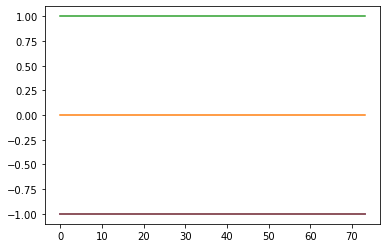

In [25]:
x = []
y = []
for theta in optim.theta_trace:
    x.append(theta[0]['delt_d']['mu'])
    y.append(theta[1]['delt_d']['log_sig'])
    
plt.plot(x)
plt.plot(y)

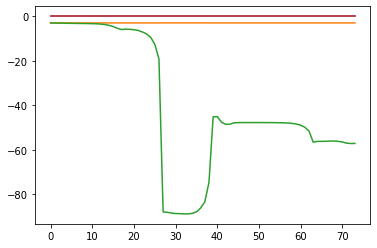

In [26]:
x = []
y = []
for eta in optim.eta_trace:
    x.append(eta[0].flatten())
    #y.append(eta[1])
    
plt.plot(x)
#plt.plot(y)

# Unit Tests

In [27]:
optim.E_step()

In [28]:
delta = 0.0001

ll0 = optim.get_log_like()

optim.eta[1][1][2,0] += delta
optim.get_log_Gamma(jump=True)
optim.get_log_Gamma(jump=False)
optim.get_log_delta()

ll1 = optim.get_log_like()

optim.eta[1][1][2,0] -= delta
optim.get_log_Gamma(jump=True)
optim.get_log_Gamma(jump=False)
optim.get_log_delta()

print((ll1 - ll0) / delta)

print(optim.grad_eta[1][1][2,0])

0.0044513444663607515
0.005292622353740723


In [29]:
optim.grad_eta

[array([[ 0.00000000e+00,  1.06177176e-26],
        [-1.18460523e-23,  0.00000000e+00]]),
 [array([[ 0.00000000e+00,  7.19299207e-27, -3.47800435e-70],
         [ 8.52091941e-67,  0.00000000e+00, -1.28155201e-26],
         [ 1.34381256e-67,  1.54860115e-69,  0.00000000e+00]]),
  array([[0.00000000e+00, 2.30496426e-03, 1.05041940e-40],
         [5.88350349e-39, 0.00000000e+00, 6.81093829e-04],
         [5.29262235e-03, 4.26260741e-40, 0.00000000e+00]])]]